[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Auto Train YOLOv8 Model with Autodistill

Autodistill uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Image dataset preperation
- Autolabel dataset
- Train target model
- Evaluate target model
- Run video inference
- Upload dataset and model to Roboflow (comming soon)

## 🔥 Let's begin!


## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [57]:
!nvidia-smi

Thu Mar  7 16:21:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000             WDDM  | 00000000:61:00.0  On |                  Off |
| 30%   35C    P8              15W / 230W |  11987MiB / 24564MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [58]:
# !pip install -q \
# autodistill \
# autodistill-grounded-sam \
# autodistill-yolov8 \
# roboflow \
# supervision==0.9.0

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [59]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label


In [60]:
import shutil

# Specify the file or directory path to remove
file_or_directory_path = os.path.join(HOME, "runs")
try:
    if os.path.isfile(file_or_directory_path):
        os.remove(file_or_directory_path)
        print(f"File {file_or_directory_path} removed successfully.")
    elif os.path.isdir(file_or_directory_path):
        shutil.rmtree(file_or_directory_path)
        print(f"Directory {file_or_directory_path} and its contents removed successfully.")
    else:
        print(f"Path {file_or_directory_path} does not exist.")
except Exception as e:
    print(f"Error removing file or directory: {e}")

file_or_directory_path = os.path.join(HOME, "images")
try:
    if os.path.isfile(file_or_directory_path):
        os.remove(file_or_directory_path)
        print(f"File {file_or_directory_path} removed successfully.")
    elif os.path.isdir(file_or_directory_path):
        shutil.rmtree(file_or_directory_path)
        print(f"Directory {file_or_directory_path} and its contents removed successfully.")
    else:
        print(f"Path {file_or_directory_path} does not exist.")
except Exception as e:
    print(f"Error removing file or directory: {e}")

file_or_directory_path = os.path.join(HOME, "dataset")
try:
    if os.path.isfile(file_or_directory_path):
        os.remove(file_or_directory_path)
        print(f"File {file_or_directory_path} removed successfully.")
    elif os.path.isdir(file_or_directory_path):
        shutil.rmtree(file_or_directory_path)
        print(f"Directory {file_or_directory_path} and its contents removed successfully.")
    else:
        print(f"Path {file_or_directory_path} does not exist.")
except Exception as e:
    print(f"Error removing file or directory: {e}")


file_or_directory_path = os.path.join(HOME, "annotated_images")
try:
    if os.path.isfile(file_or_directory_path):
        os.remove(file_or_directory_path)
        print(f"File {file_or_directory_path} removed successfully.")
    elif os.path.isdir(file_or_directory_path):
        shutil.rmtree(file_or_directory_path)
        print(f"Directory {file_or_directory_path} and its contents removed successfully.")
    else:
        print(f"Path {file_or_directory_path} does not exist.")
except Exception as e:
    print(f"Error removing file or directory: {e}")

Path c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label\runs does not exist.
Directory c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label\images and its contents removed successfully.
Directory c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label\dataset and its contents removed successfully.
Directory c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label\annotated_images and its contents removed successfully.


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images that you want to automatically annotate, and use for target model training.

In [61]:
images_dir = os.path.join(HOME, "images")

try:
    os.mkdir(images_dir)
    print(f"Directory {images_dir} created successfully.")
except FileExistsError:
    print(f"Directory {images_dir} already exists.")
except Exception as e:
    print(f"Error creating directory: {e}")

Directory c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label\images created successfully.


## Download Images

Below, we provide two methods of retrieving images for use with Autodistill:

1. Download a dataset with images from Roboflow, and;
2. Download a raw video and split it up into images.

For this guide, we will be using a raw video to train our model.

### Download Images from Roboflow

You can download datasets from Roboflow using the below lines of code. You can download datasets associated with your account, or any of the 200,000+ public datasets on [Roboflow Universe](https://universe.roboflow.com/). To download a dataset from Roboflow, you will need a [free Roboflow account](https://app.roboflow.com).

You need to paste in a URL to a full model, like so:

```
https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16
```

To find a model URL, go to a dataset page on Universe (i.e. the [TACO dataset](https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/)), then click "Model" in the sidebar to view the latest model version. Copy the page URL, then paste it into the `download_dataset()` function below.

![Universe model link](https://media.roboflow.com/universe_deploy_tab.png)

Uncomment the lines of code below to use the Roboflow dataset upload.

In [62]:
# import roboflow

# roboflow.login()

# dataset = roboflow.download_dataset(dataset_url="https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16", model_format="yolov8")

Once you have downloaded your dataset, move all of the images from the `train` set in your downloaded dataset into the `images/` directory we created earlier:

In [63]:
# %mv {HOME}/<dataset-name>/train/* {HOME}/images

Now we are ready to start using Autodistill!

### Download raw videos

**NOTE:** In this tutorial, we will start with a directory containing video files and I will show you how to turn it into a ready-to-use collection of images. If you are working with your images, you can skip this part.

In [64]:
# import zipfile
# import requests

# # Create the videos directory
# videos_dir = os.path.join(HOME, "videos")

# try:
#     os.mkdir(videos_dir)
#     print(f"Directory {videos_dir} created successfully.")
# except FileExistsError:
#     print(f"Directory {videos_dir} already exists.")
# except Exception as e:
#     print(f"Error creating directory: {e}")

# # Change current working directory to the videos directory
# os.chdir(videos_dir)

# # Download zip file containing videos
# zip_url = "https://media.roboflow.com/milk.zip"
# zip_filename = os.path.join(videos_dir, "milk.zip")

# try:
#     response = requests.get(zip_url, stream=True)
#     with open(zip_filename, "wb") as zip_file:
#         for chunk in response.iter_content(chunk_size=128):
#             zip_file.write(chunk)
#     print(f"Zip file {zip_filename} downloaded successfully.")
# except Exception as e:
#     print(f"Error downloading zip file: {e}")

# # Unzip videos
# try:
#     with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
#         zip_ref.extractall(videos_dir)
#     print(f"Zip file {zip_filename} successfully extracted.")
# except Exception as e:
#     print(f"Error extracting zip file: {e}")

### Convert videos into images

**NOTE:** Now, let's convert videos into images. By default, the code below saves every `10th` frame from each video. You can change this by manipulating the value of the `FRAME_STRIDE` parameter.

In [65]:
# VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
# FRAME_STRIDE = 10

**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [66]:
# import supervision as sv
# from tqdm.notebook import tqdm

# video_paths = sv.list_files_with_extensions(
#     directory=VIDEO_DIR_PATH,
#     extensions=["mov", "mp4"])

# TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

# for video_path in tqdm(TRAIN_VIDEO_PATHS):
#     video_name = video_path.stem
#     image_name_pattern = video_name + "-{:05d}.png"
#     with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
#         for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
#             sink.save_image(image=image)

In [67]:
import os
from PIL import Image

def convert_images_to_png(source_folder, output_folder):
    """
    Converts all images in the source_folder to .png format and saves them to the output_folder.
    """
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the source folder
    for filename in os.listdir(source_folder):
        if not filename.startswith('.'):  # Ignore hidden files
            # Construct the full file path
            file_path = os.path.join(source_folder, filename)
            # Attempt to open the image file
            try:
                with Image.open(file_path) as img:
                    # Construct the output file path
                    base_filename, _ = os.path.splitext(filename)
                    output_file = os.path.join(output_folder, f"{base_filename}.png")
                    # Convert and save the image in .png format
                    img.save(output_file, "PNG")
                    print(f"Converted and saved: {output_file}")
            except IOError:
                print(f"Failed to convert {filename}. It might not be an image file.")

# Example usage
source_folder = os.path.join(HOME, "images_input")
output_folder = IMAGE_DIR_PATH

convert_images_to_png(source_folder, output_folder)


Converted and saved: c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label/images\video42_frame013.png
Converted and saved: c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label/images\video42_frame017.png
Converted and saved: c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label/images\video42_frame052.png
Converted and saved: c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label/images\video42_frame053.png
Converted and saved: c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label/images\video43_frame001.png
Converted and saved: c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label/images\video43_frame005.png
Converted and saved: c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label/images\video43_frame011.png
Converted and saved: c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_la

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [68]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 20


**NOTE:** We can also plot sample of our image dataset.

In [69]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

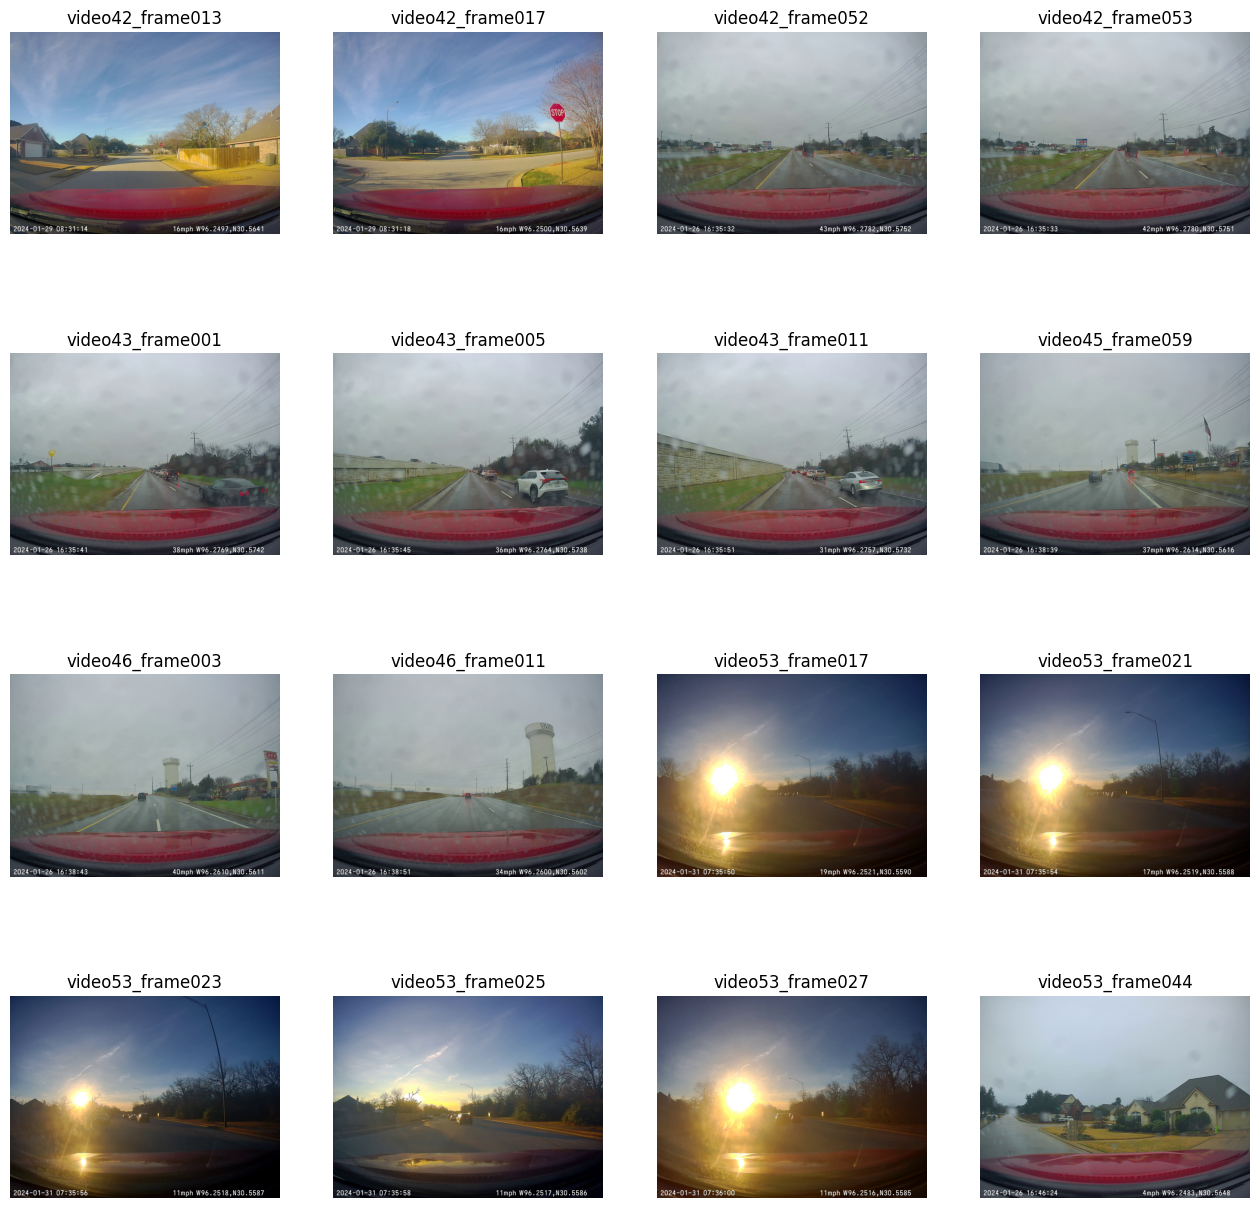

In [70]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [71]:
from autodistill.detection import CaptionOntology


ontology=CaptionOntology({
    
    "garbage truck, large truck": "truck",
    "car, semi-truck": "car",
    # "cat" : "cat",
    # "dog" :"dog",
    # "sheep": "sheep", 
    # "cow" : "cow",
    # "horse" : "horse" ,
    # "semi-truck" : "semi-truck",
    # "garbage truck" : "garbage truck",
    # "bus" : "bus",
    # "stop sign" : "stop sign",
    # "green traffic light" : "green traffic light",
    # "yellow traffic light" : "yellow traffic light",
    # "red traffic light" : "red traffic light",
    # "trash bin" : "trash bin",
    # "scooter" : "scooter",
    # "bicycle" : "bicycle",
    # "motorbike" : "motorbike",
    # "construction" : "construction barrels",
    # "trafficBarrel" : "traffic barrel, traffic cones, barrels",
    # "pedestrians" : "pedestrians and people",
    "sports ball" : "sports ball",
    # "frisbee" : "frisbee",
})

# ontology=CaptionOntology({
#     "car": "car",
#     "truck": "truck",
#     "cat" : "cat",
#     "dog" :"dog",
#     "sheep": "sheep", 
#     "cow" : "cow",
#     "horse" : "horse" ,
#     "semi-truck" : "semi-truck",
#     "garbage truck" : "garbage truck",
#     "bus" : "bus",
#     "stop sign" : "stop sign",
#     "green traffic light" : "green traffic light",
#     "yellow traffic light" : "yellow traffic light",
#     "red traffic light" : "red traffic light",
#     "trash bin" : "trash bin",
#     "scooter" : "scooter",
#     "bicycle" : "bicycle",
#     "motorbike" : "motorbike",
#     "construction" : "construction (barriers)",
#     "trafficBarrel" : "traffic barrel, traffic cones, barrels",
#     "pedestrians" : "pedestrians and people",
#     "sports ball" : "sports ball",
#     "frisbee" : "frisbee",
# })

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [72]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [73]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling c:\Users\timothy.b.joseph\Documents\NeuralNavigator\neural_navigator\auto_label/images\video53_frame060.png: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [74]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [75]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

16

In [76]:
import supervision as sv

SAMPLE_PLOT_SIZE = (300, 300)

image_names = list(dataset.images.keys())[:20]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

print(dataset.classes)

output_directory = f"{HOME}/annotated_images"
os.makedirs(output_directory, exist_ok=True)


images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    # print(annotations.class_id)
    # labels = []
    # for class_id in annotations.class_id:
    #     if class_id < len(dataset.classes):
    #         labels.append(dataset.classes[class_id])
    #     else:
    #         print(f"Error: class_id {class_id} is out of range for dataset.classes. Max index: {len(dataset.classes)-1}")
    # labels = []
    # for class_id in annotations.class_id:
    #     try:
    #         labels.append(dataset.classes[class_id])
    #     except IndexError:
    #         print(f"Error: class_id {class_id} is out of range for dataset.classes")
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

    output_path = os.path.join(output_directory, f"{image_name}_annotated.png")

    with sv.ImageSink(target_dir_path=output_path) as sink:
        sink.save_image(image=annotates_image)

# sv.plot_images_grid(
#     images=images,
#     titles=image_names,
#     grid_size=SAMPLE_GRID_SIZE,
#     size=SAMPLE_PLOT_SIZE)


['truck', 'car', 'sports ball']


## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [77]:
# %cd {HOME}

# from autodistill_yolov8 import YOLOv8

# target_model = YOLOv8("yolov8n.pt")
# target_model.train(DATA_YAML_PATH, epochs=100)

In [78]:
# directory_path = os.path.join(HOME, "runs", "detect", "train")

# # List the contents of the directory
# try:
#     files = os.listdir(directory_path)
#     print(f"Contents of {directory_path}:")
#     for file in files:
#         print(file)
# except FileNotFoundError:
#     print(f"Directory {directory_path} not found.")
# except Exception as e:
#     print(f"Error listing directory contents: {e}")

## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

In [79]:
# %cd {HOME}

# from IPython.display import Image

# confusion_matrix = os.path.join(HOME, "runs", "detect", "train", "confusion_matrix.png")

# Image(filename=confusion_matrix, width=600)

In [80]:
# %cd {HOME}

# from IPython.display import Image

# Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

In [81]:
# %cd {HOME}

# from IPython.display import Image

# Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [82]:
# INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
# OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
# TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [83]:
# !yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

## Upload dataset and model to Roboflow

In [84]:
# import roboflow
# from roboflow import Roboflow
# import supervision as sv
# from tqdm.notebook import tqdm
# import os

# # Login to Roboflow
# roboflow.login()

# # Access your workspace
# workspace = Roboflow().workspace()

# # Assuming `dataset.name` is available from the previous steps
# # Replace 'your_dataset_name_here' with the actual name of your dataset
# dataset_name = 'upload-test'

# # Create a new project in Roboflow
# new_project = workspace.create_project(
#     project_name=dataset_name,
#     project_license="MIT",
#     project_type="instance-segmentation",
#     annotation=f"{dataset_name}-yolo-format")

# # Directory paths
# IMAGE_DIR_PATH = f"{HOME}/dataset/train/images"
# ANNOTATIONS_DIR_PATH = f"{HOME}/dataset/train/labels"

# # List all image files
# image_paths = sv.list_files_with_extensions(directory=IMAGE_DIR_PATH, extensions=["jpg", "jpeg", "png"])

# # Upload images and their annotations to Roboflow
# for image_path in tqdm(image_paths):
#     image_name = image_path.name
#     annotation_name = f"{image_path.stem}.txt"  # YOLO annotations are .txt files
#     annotation_path = os.path.join(ANNOTATIONS_DIR_PATH, annotation_name)
    
#     # Only upload if the annotation file exists for the image
#     if os.path.exists(annotation_path):
#         new_project.upload(
#             image_path=str(image_path),
#             annotation_path=annotation_path,
#             split="train",  # Assuming all images are for training
#             is_prediction=False,  # These are ground-truth annotations
#             overwrite=True,  # Overwrite existing files if necessary
#             tag_names=["auto-annotated-with-autodistill"],
#             batch_name="auto-annotated-batch"
#         )


  # 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.